In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("test_pyspark") \
    .config("spark.driver.memory", "100g") \
    .config("spark.executor.memory", "100g") \
    .config("spark.sql.orc.enableVectorizedReader", "false") \
    .config("spark.sql.parquet.columnarReaderBatchSize", "256") \
    .config("spark.sql.orc.columnarReaderBatchSize", "256") \
    .config("spark.sql.shuffle.partitions", "1024") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/17 12:42:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df_sentences = spark.table("alto_sentence")
df_sentences.printSchema()

root
 |-- id: string (nullable = true)
 |-- sentence: string (nullable = true)
 |-- sentence_idx: integer (nullable = true)



# Create Sample of Sentences

In [ ]:
#spark.table("alto_sentence").sample(False, 0.01, seed=42).write.mode("overwrite").saveAsTable("alto_sentence_sample_001pct")

In [2]:
df_sentences = spark.table("alto_sentence_sample_001pct")

# Sentence-Level Text Analysis

Now that we have successfully created a DataFrame of sentences from the ALTO text, we'll perform various text analyses similar to those in the works_text_analysis notebook. We'll analyze:

1. Basic sentence statistics (length, word count, etc.)
2. Visualize distributions with histograms and boxplots
3. Term frequency and common words analysis
4. N-gram analysis to identify common phrases
5. Sentiment and subjectivity analysis
6. Named entity recognition
7. Text readability and complexity metrics

In [6]:
# Import necessary libraries for text analysis and visualization
import pyspark.sql.functions as F
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Configure matplotlib for better display
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

In [ ]:
# Create a DataFrame with sentence statistics
sentence_stats = df_sentences.select(
    "id",
    "sentence",
    "sentence_idx",
    F.length("sentence").alias("sentence_length"),
    F.size(F.split("sentence", "\\s+")).alias("word_count")
)

# Show schema and sample data
sentence_stats.printSchema()

root
 |-- id: string (nullable = true)
 |-- sentence: string (nullable = true)
 |-- sentence_idx: integer (nullable = true)
 |-- sentence_length: integer (nullable = true)
 |-- word_count: integer (nullable = false)



In [9]:
# Calculate summary statistics
summary_stats = sentence_stats.summary()
sentence_stats_pd = sentence_stats.toPandas()
sentence_stats_pd.to_csv("../data/tmp/sentence_stats_sample.csv", index=False)

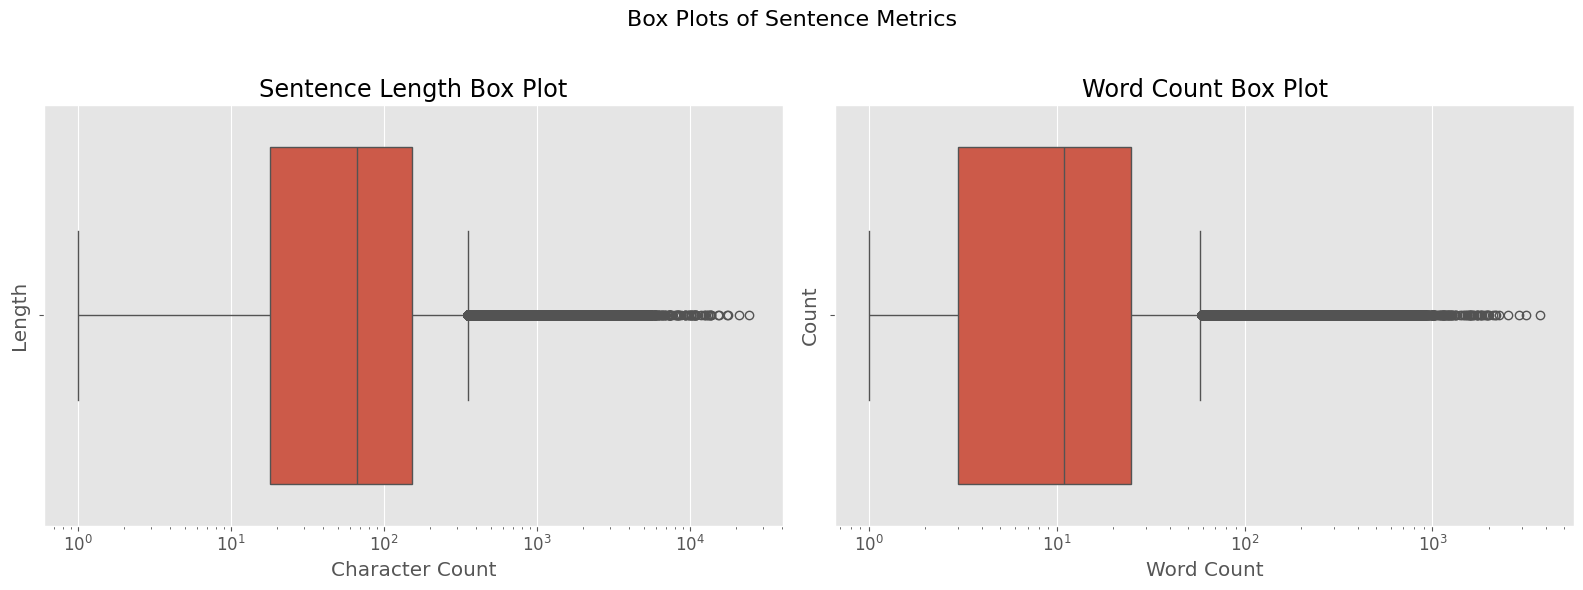

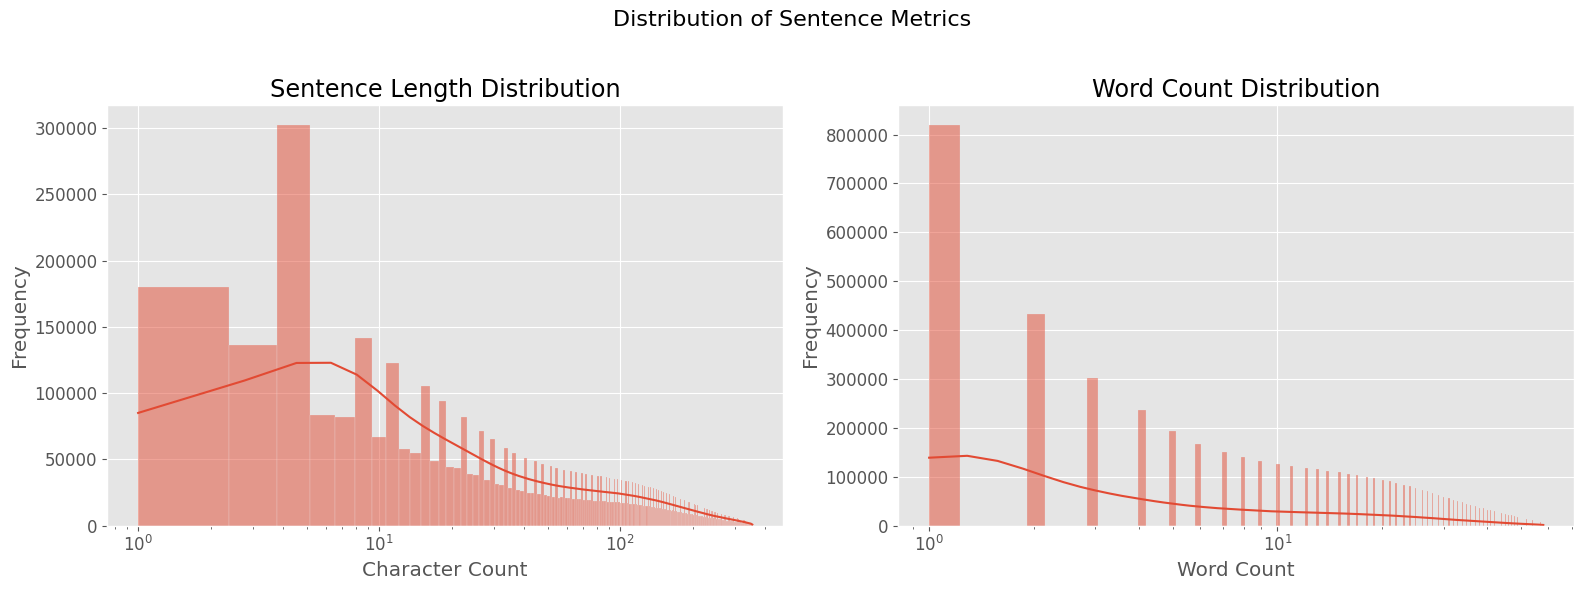

In [11]:
# Convert statistics to pandas for visualization (using a sample for better performance)
sentence_stats_pd = pd.read_csv("../data/tmp/sentence_stats_sample.csv")

# Make box plots for sentence length and word count
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Box Plots of Sentence Metrics', fontsize=16)
# Plot box plot for sentence length
sns.boxplot(x=sentence_stats_pd['sentence_length'], ax=axes[0])
# Plot box plot for word count
sns.boxplot(x=sentence_stats_pd['word_count'], ax=axes[1])
axes[0].set_title('Sentence Length Box Plot')
axes[0].set_xlabel('Character Count')
axes[0].set_ylabel('Length')
axes[1].set_title('Word Count Box Plot')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Count')
axes[0].set_xscale('log')
axes[1].set_xscale('log')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Remove outliers from the sentence length and word count for better visualization
# Determine thresholds for outliers first

q1_length = sentence_stats_pd['sentence_length'].quantile(0.25)
q3_length = sentence_stats_pd['sentence_length'].quantile(0.75)
iqr_length = q3_length - q1_length
q1_word_count = sentence_stats_pd['word_count'].quantile(0.25)
q3_word_count = sentence_stats_pd['word_count'].quantile(0.75)
iqr_word_count = q3_word_count - q1_word_count
# Define outlier thresholds
lower_bound_length = q1_length - 1.5 * iqr_length
upper_bound_length = q3_length + 1.5 * iqr_length
lower_bound_word_count = q1_word_count - 1.5 * iqr_word_count
upper_bound_word_count = q3_word_count + 1.5 * iqr_word_count
# Filter out outliers
sentence_stats_pd = sentence_stats_pd[
    (sentence_stats_pd['sentence_length'] >= lower_bound_length) &
    (sentence_stats_pd['sentence_length'] <= upper_bound_length) &
    (sentence_stats_pd['word_count'] >= lower_bound_word_count) &
    (sentence_stats_pd['word_count'] <= upper_bound_word_count)
]

# Create a figure with subplots for histograms of sentence length and word count
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Distribution of Sentence Metrics', fontsize=16)

# Plot histogram with KDE for sentence length
sns.histplot(sentence_stats_pd['sentence_length'].dropna(), kde=True, ax=axes[0])
axes[0].set_title('Sentence Length Distribution')
axes[0].set_xlabel('Character Count')
axes[0].set_ylabel('Frequency')

# Plot histogram with KDE for word count
sns.histplot(sentence_stats_pd['word_count'].dropna(), kde=True, ax=axes[1])
axes[1].set_title('Word Count Distribution')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[0].set_xscale('log')
axes[1].set_xscale('log')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Term Frequency Analysis

Let's explore the most common words in the sentences to understand the content better.

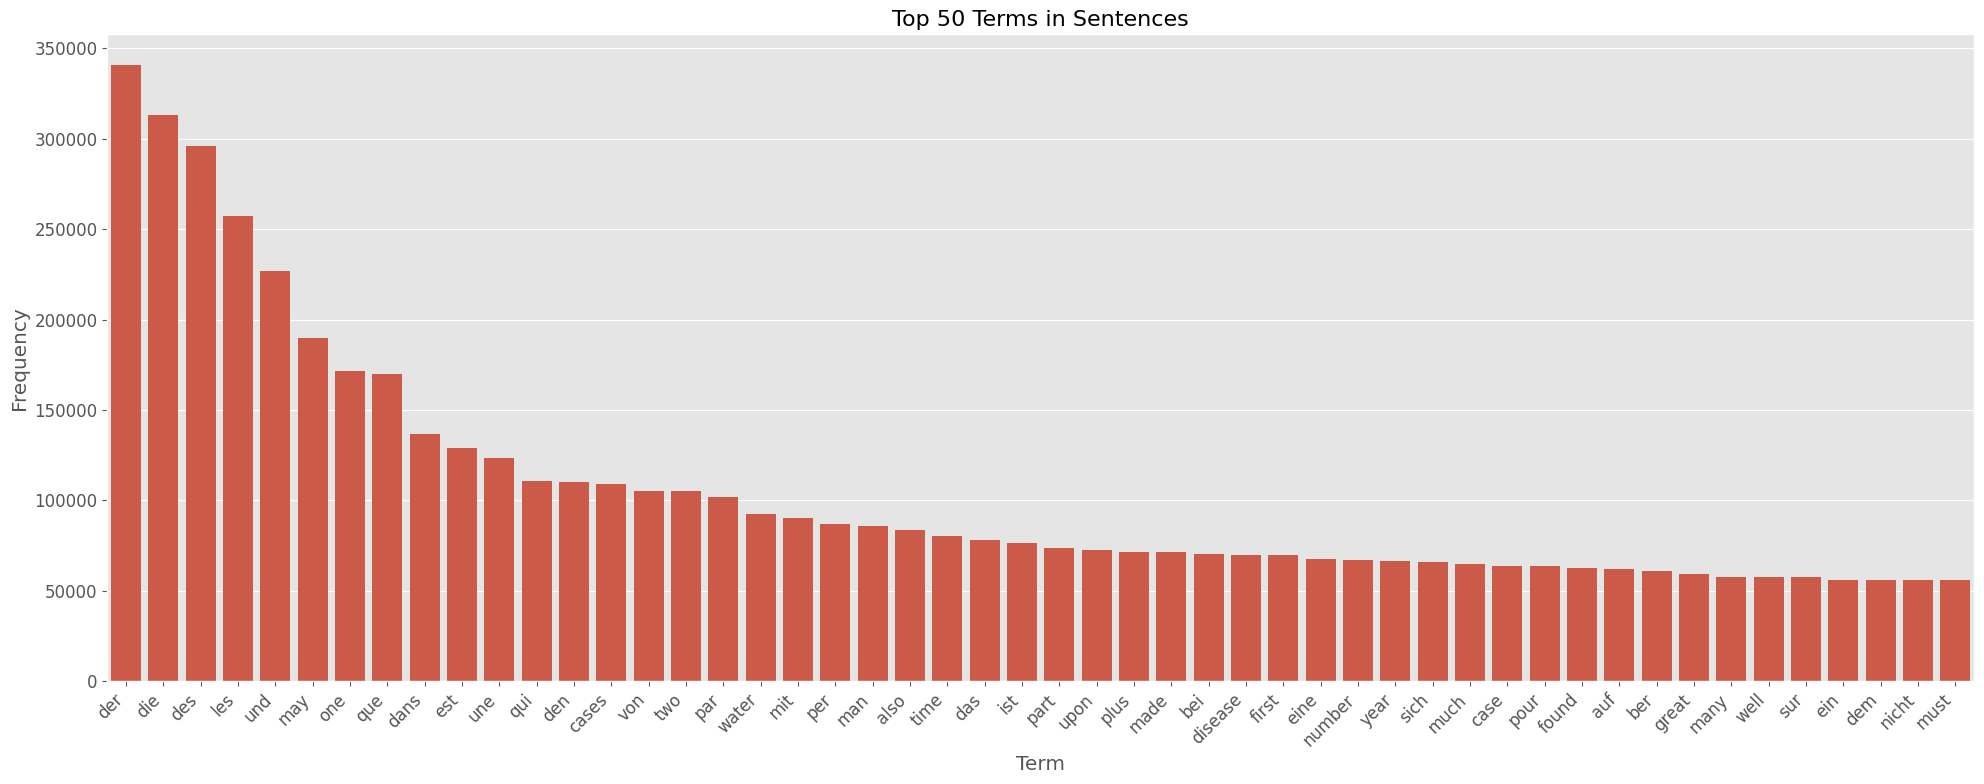

In [10]:
# Term frequency analysis for sentences
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, StopWordsRemover
from pyspark.sql.functions import explode, col
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, StringType, StructType, StructField, IntegerType

df_sentences = spark.table("alto_sentence_sample_001pct")
# Select non-empty sentences
sentences_df = df_sentences.filter(F.length("sentence") > 0).select("id", "sentence_idx", "sentence")

# 1) Split on non-word chars (keeps only letters & numbers)
regex_tokenizer = RegexTokenizer(
    inputCol="sentence",
    outputCol="words",
    pattern="\\W+",        # splits on anything other than [A-Za-z0-9_]
    minTokenLength=2       # drop 1-letter "words"
)
sentences_words_df = regex_tokenizer.transform(sentences_df)

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
sentences_filtered_df = remover.transform(sentences_words_df)

# Create a custom UDF to filter out numbers and short tokens
@F.udf(returnType=ArrayType(StringType()))
def clean_tokens(tokens):
    if not tokens:
        return []
    return [token.lower() for token in tokens if len(token) > 2 and not token.isdigit()]

sentences_cleaned_df = sentences_filtered_df.withColumn(
    "clean_words", clean_tokens(col("filtered_words")))

# Calculate term frequencies
cv = CountVectorizer(inputCol="clean_words", outputCol="term_freq", minDF=5, vocabSize=10000)
sentences_cv_model = cv.fit(sentences_cleaned_df)
sentences_term_freq_df = sentences_cv_model.transform(sentences_cleaned_df)

# Extract vocabulary from the CountVectorizerModel
sentences_vocab = sentences_cv_model.vocabulary

# Function to extract term counts
def extract_term_counts_fn(vocab_list):
    @F.udf(returnType=ArrayType(StructType([
        StructField("term", StringType()),
        StructField("count", IntegerType())
    ])))
    def extract(vector):
        indices = vector.indices.tolist()
        values = vector.values.tolist()
        return [(vocab_list[idx], int(val))
                for idx, val in zip(indices, values)]
    return extract

# Apply the function using closure
sentences_term_counts_df = sentences_term_freq_df.withColumn(
    "term_counts",
    extract_term_counts_fn(sentences_vocab)(col("term_freq"))
)

# Explode the array to get individual term-count pairs
sentences_exploded_df = sentences_term_counts_df.select(
    "id",
    "sentence_idx",
    explode("term_counts").alias("term_count")
)

# Extract term and count from the struct
sentences_term_count_df = sentences_exploded_df.select(
    "id", 
    "sentence_idx",
    col("term_count.term").alias("term"),
    col("term_count.count").alias("count")
)

# Group by term and sum counts
sentences_term_totals = sentences_term_count_df.groupBy(
    "term").agg(F.sum("count").alias("total_count"))

top_terms = sentences_term_totals.orderBy(col("total_count").desc()).limit(50)
sentences_top_terms_pd = top_terms.toPandas()

# Plot top terms
plt.figure(figsize=(20, 8))
sns.barplot(x="term", y="total_count", data=sentences_top_terms_pd)
plt.title('Top 50 Terms in Sentences', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Term')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

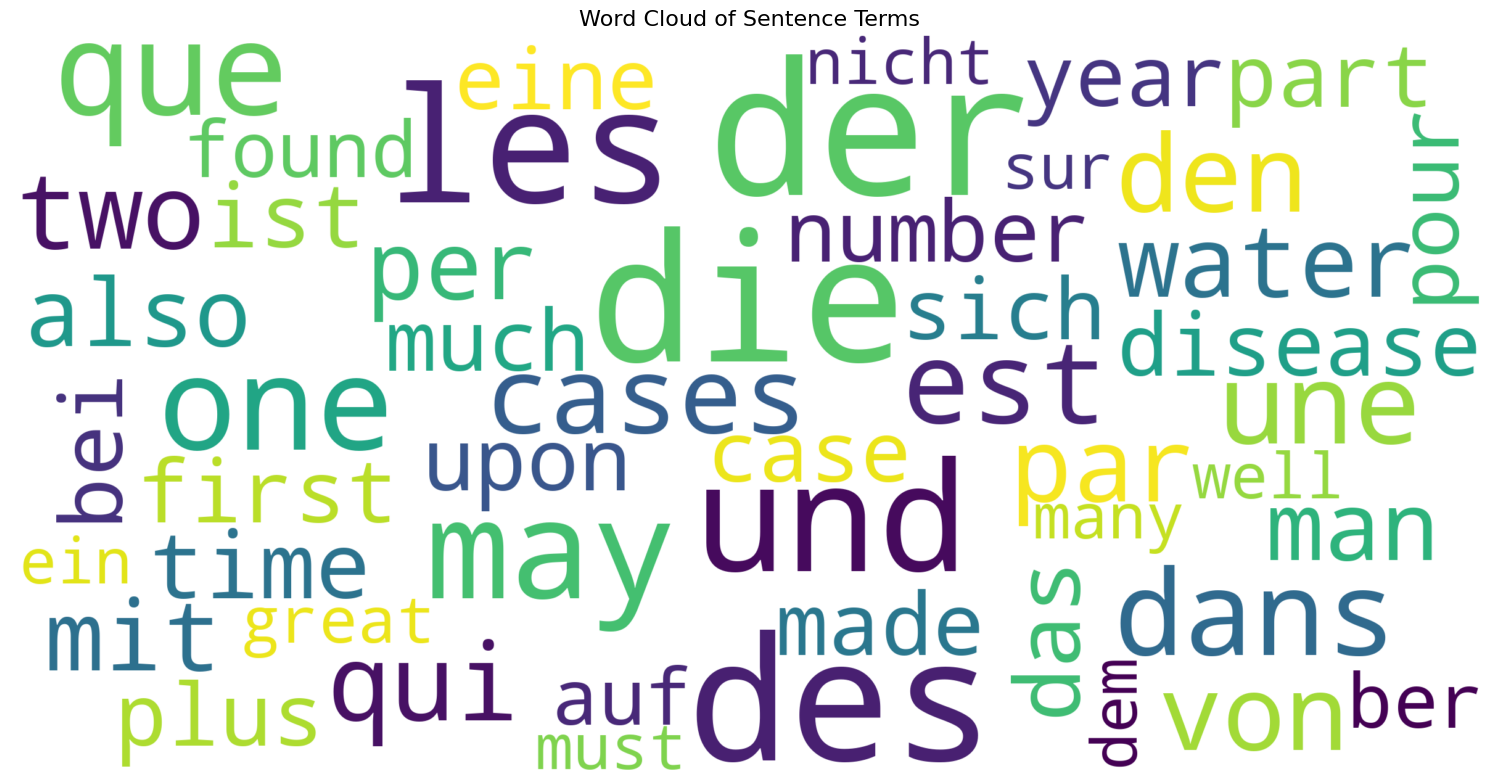

In [13]:
# Generate a word cloud visualization
try:
    from wordcloud import WordCloud
    
    # Create a dictionary from the top terms dataframe
    sentences_word_freq = dict(zip(sentences_top_terms_pd['term'], sentences_top_terms_pd['total_count']))
    
    # Generate word cloud
    sentences_wordcloud = WordCloud(
        width=800, height=400, background_color='white', max_words=100,
        max_font_size=100, scale=3, random_state=42).generate_from_frequencies(
        sentences_word_freq)
    
    plt.figure(figsize=(16, 8))
    plt.imshow(sentences_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Sentence Terms', fontsize=16)
    plt.tight_layout()
    plt.show()
except ImportError:
    print("WordCloud package not available. Install using: pip install wordcloud")

## N-gram Analysis

Let's analyze common phrases (bigrams and trigrams) to identify multi-word expressions and common patterns in the sentences.

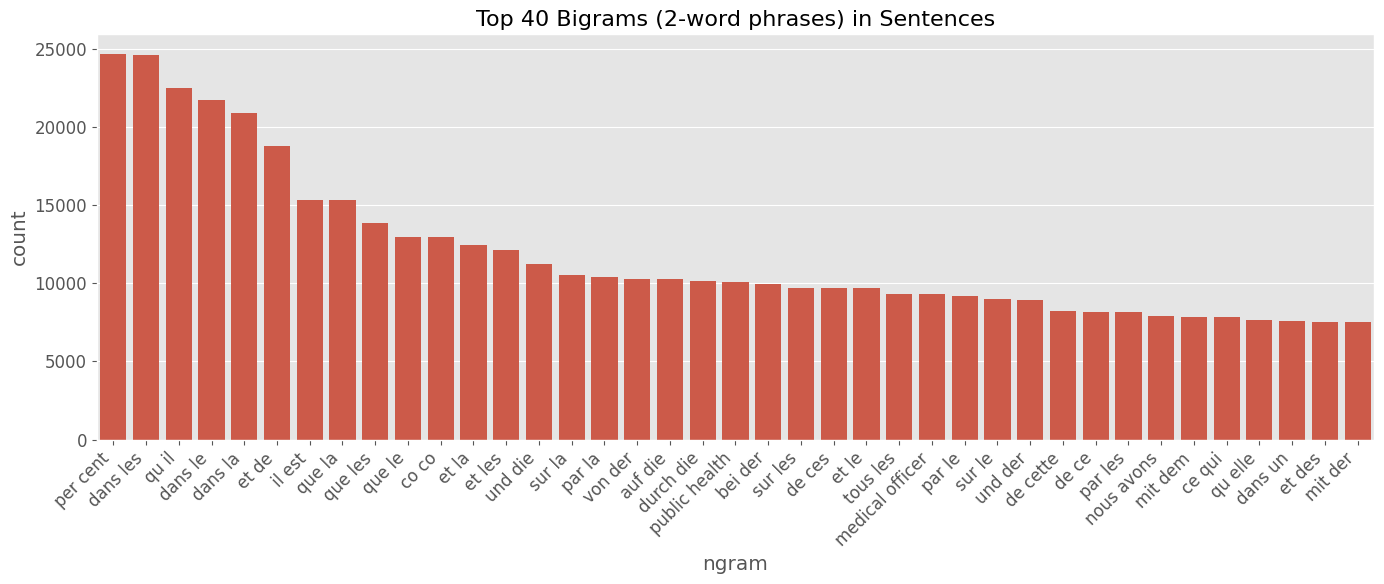

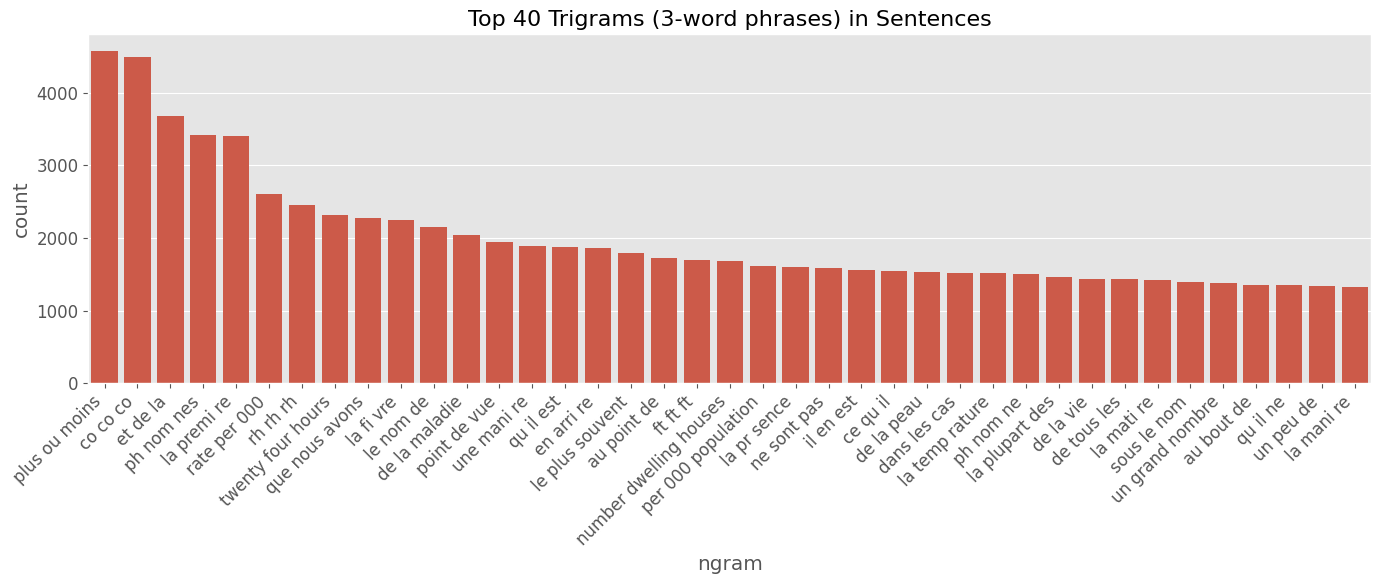

In [14]:
# N-gram analysis to identify common phrases in sentences
from pyspark.ml.feature import NGram

# Add bigrams (2-word phrases)
bigram = NGram(n=2, inputCol="filtered_words", outputCol="bigrams")
sentences_bigram_df = bigram.transform(sentences_filtered_df)

# Add trigrams (3-word phrases)
trigram = NGram(n=3, inputCol="filtered_words", outputCol="trigrams")
sentences_ngram_df = trigram.transform(sentences_bigram_df)

# Function to get top n-grams
def get_top_ngrams(df, ngram_col, n=40):
    # Explode the n-grams to get individual entries
    exploded_df = df.select(explode(col(ngram_col)).alias("ngram"))
    
    # Count the occurrences of each n-gram
    ngram_counts = exploded_df.groupBy("ngram").count().orderBy(col("count").desc())
    
    # Get top n n-grams
    return ngram_counts.limit(n).toPandas()

# Get top bigrams
sentences_top_bigrams = get_top_ngrams(sentences_ngram_df, "bigrams")

# Get top trigrams
sentences_top_trigrams = get_top_ngrams(sentences_ngram_df, "trigrams")

# Plot top bigrams
plt.figure(figsize=(14, 6))
sns.barplot(x="ngram", y="count", data=sentences_top_bigrams[1:])
plt.title('Top 40 Bigrams (2-word phrases) in Sentences', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot top trigrams
plt.figure(figsize=(14, 6))
sns.barplot(x="ngram", y="count", data=sentences_top_trigrams[1:])
plt.title('Top 40 Trigrams (3-word phrases) in Sentences', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Text Complexity Analysis

Let's analyze the complexity and readability of the sentences using metrics such as:
- Average word length
- Lexical diversity (ratio of unique words to total words)

In [5]:
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType

# Calculate text complexity metrics
complexity_df = df_sentences.select(
    "id",
    "sentence_idx",
    "sentence"
)

# Define UDF for calculating average word length
@F.udf(returnType=FloatType())
def avg_word_length(text):
    if not text or len(text.strip()) == 0:
        return None
    words = [w for w in text.split() if len(w.strip()) > 0]
    if not words:
        return 0.0
    return sum(len(word) for word in words) / len(words)

# Define UDF for calculating lexical diversity (unique words / total words)
@F.udf(returnType=FloatType())
def lexical_diversity(text):
    if not text or len(text.strip()) == 0:
        return None
    words = [w.lower() for w in text.split() if len(w.strip()) > 0]
    if not words:
        return 0.0
    return len(set(words)) / len(words)

# Apply the UDFs to calculate complexity metrics
complexity_analysis = complexity_df.select(
    "id",
    "sentence_idx",
    avg_word_length("sentence").alias("avg_word_length"),
    lexical_diversity("sentence").alias("lexical_diversity")
)

# Show summary of complexity metrics
complexity_analysis.summary().show()

+-------+--------+-----------------+------------------+-----------------+
|summary|      id|     sentence_idx|   avg_word_length|lexical_diversity|
+-------+--------+-----------------+------------------+-----------------+
|  count| 5545838|          5545838|           5545838|          5545838|
|   mean|    NULL|9518.787986955263| 5.153437111821988|0.935270105233561|
| stddev|    NULL|22083.61077970585|1.8517414893313675|0.094115505319809|
|    min|a2239muq|                0|               1.0|            0.025|
|    25%|    NULL|              986|          4.285714|       0.88461536|
|    50%|    NULL|             3222|               5.0|              1.0|
|    75%|    NULL|             8820|          5.840909|              1.0|
|    max|zzzyuwqy|           403972|             114.0|              1.0|
+-------+--------+-----------------+------------------+-----------------+



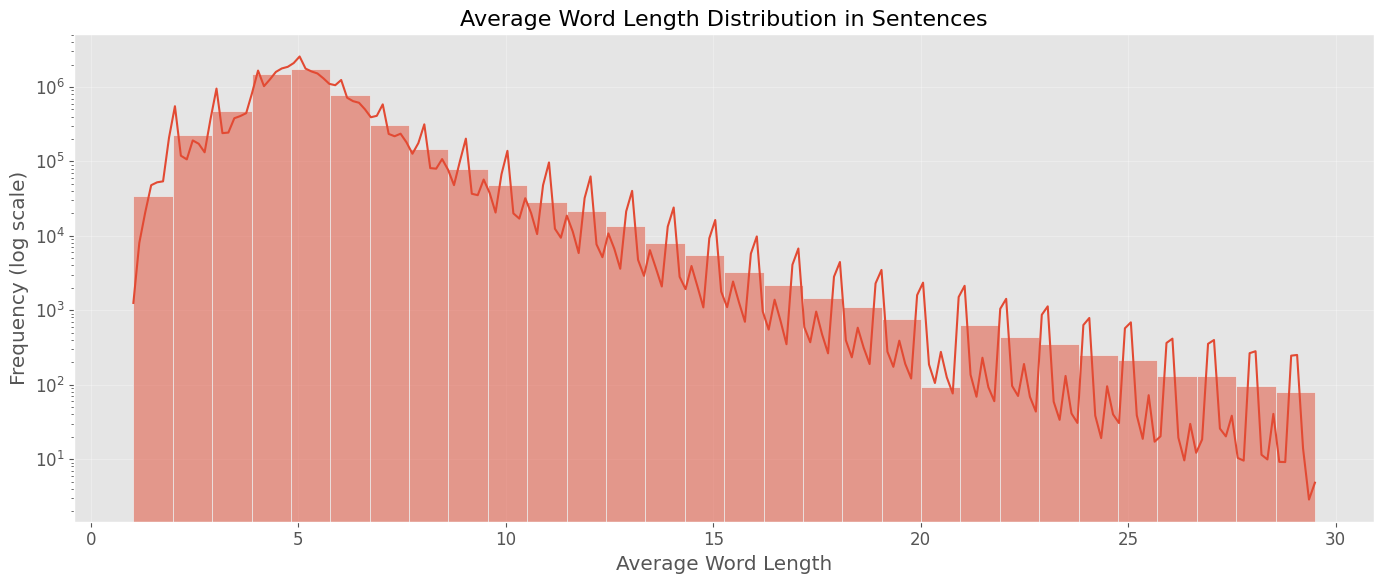

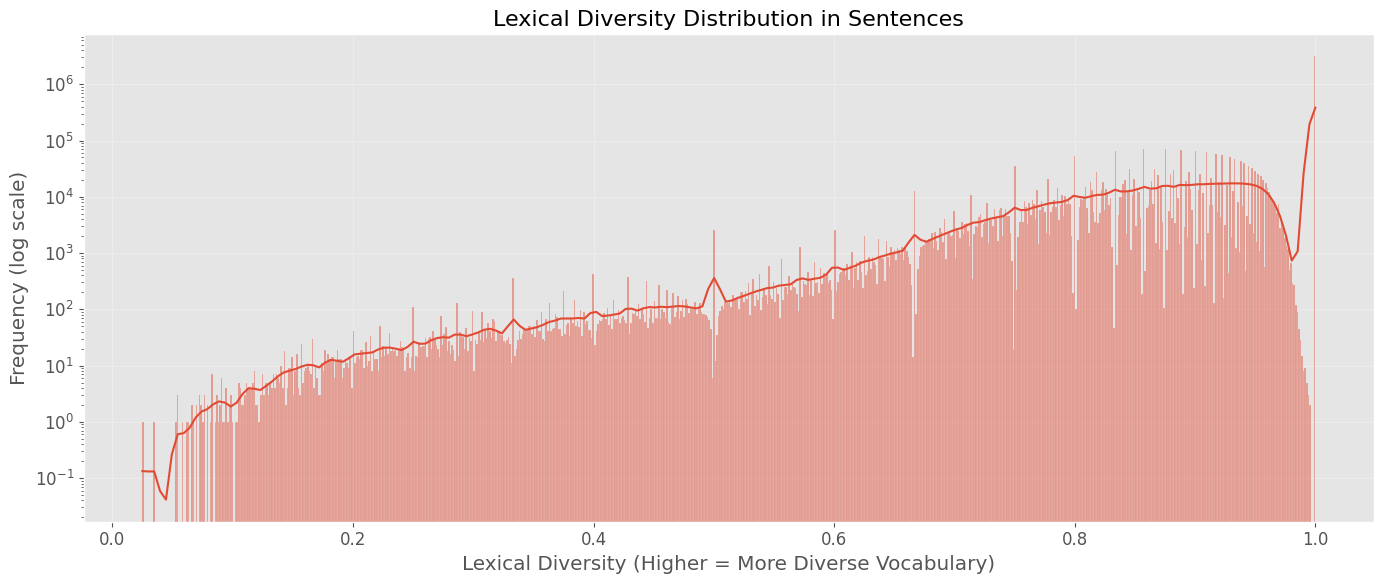

In [17]:
# Visualization of text complexity metrics
complexity_pd = complexity_analysis.toPandas()

vals = complexity_pd['avg_word_length'].dropna()
# Optionally trim:
vals_trim = vals[(vals < 30) & (vals > 1)]

# Plot average word length distribution with log-scaled y-axis
plt.figure(figsize=(14, 6))
sns.histplot(vals_trim, bins=30, stat='count', kde=True)
plt.yscale('log')
plt.title('Average Word Length Distribution in Sentences', fontsize=16)
plt.xlabel('Average Word Length')
plt.ylabel('Frequency (log scale)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot lexical diversity distribution with log-scaled y-axis
plt.figure(figsize=(14, 6))
sns.histplot(complexity_pd['lexical_diversity'].dropna(), kde=True)
plt.yscale('log')
plt.title('Lexical Diversity Distribution in Sentences', fontsize=16)
plt.xlabel('Lexical Diversity (Higher = More Diverse Vocabulary)')
plt.ylabel('Frequency (log scale)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Sentiment Analysis

Let's analyze the emotional tone and subjectivity of the sentences using TextBlob.

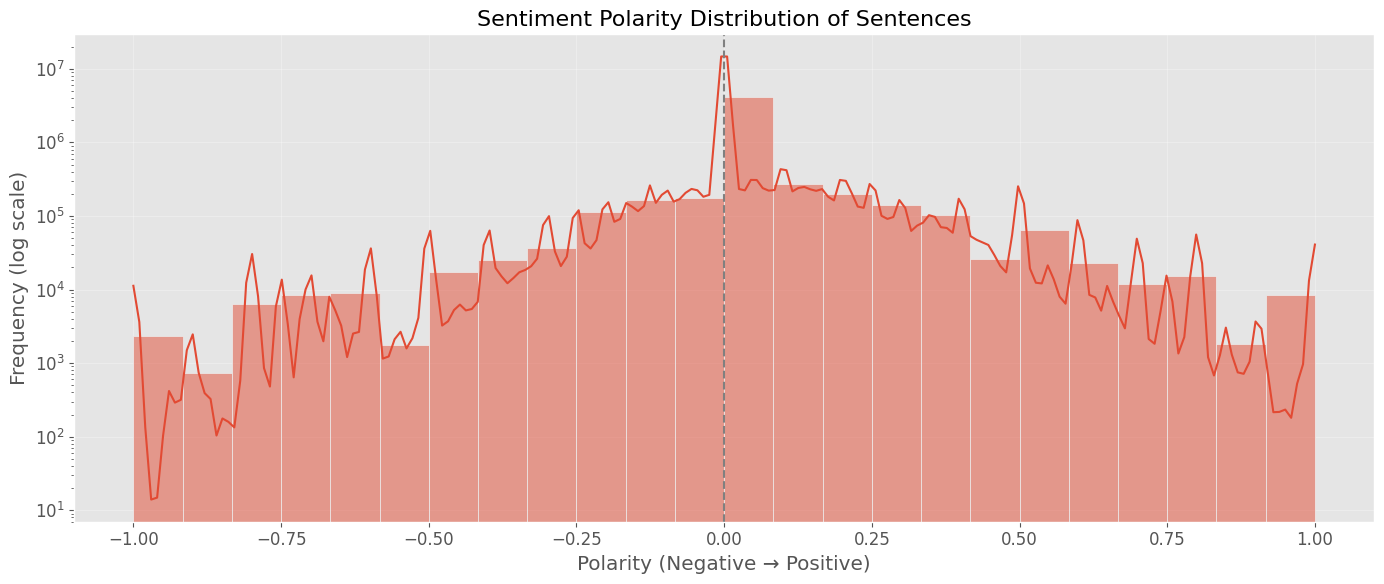

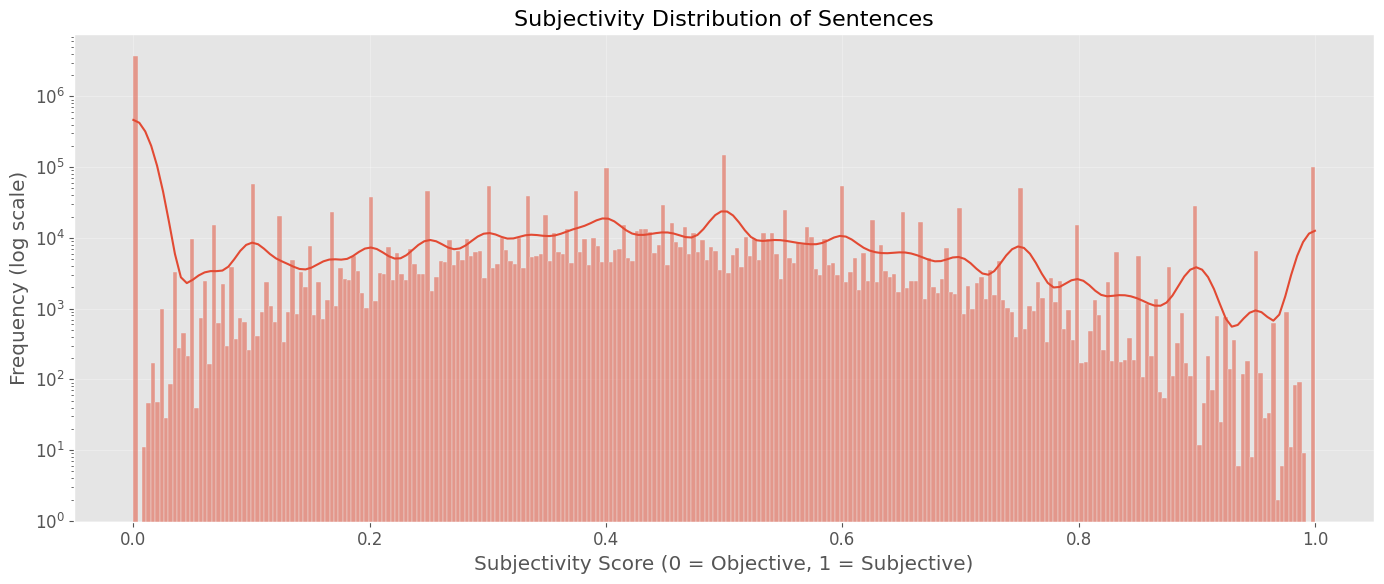

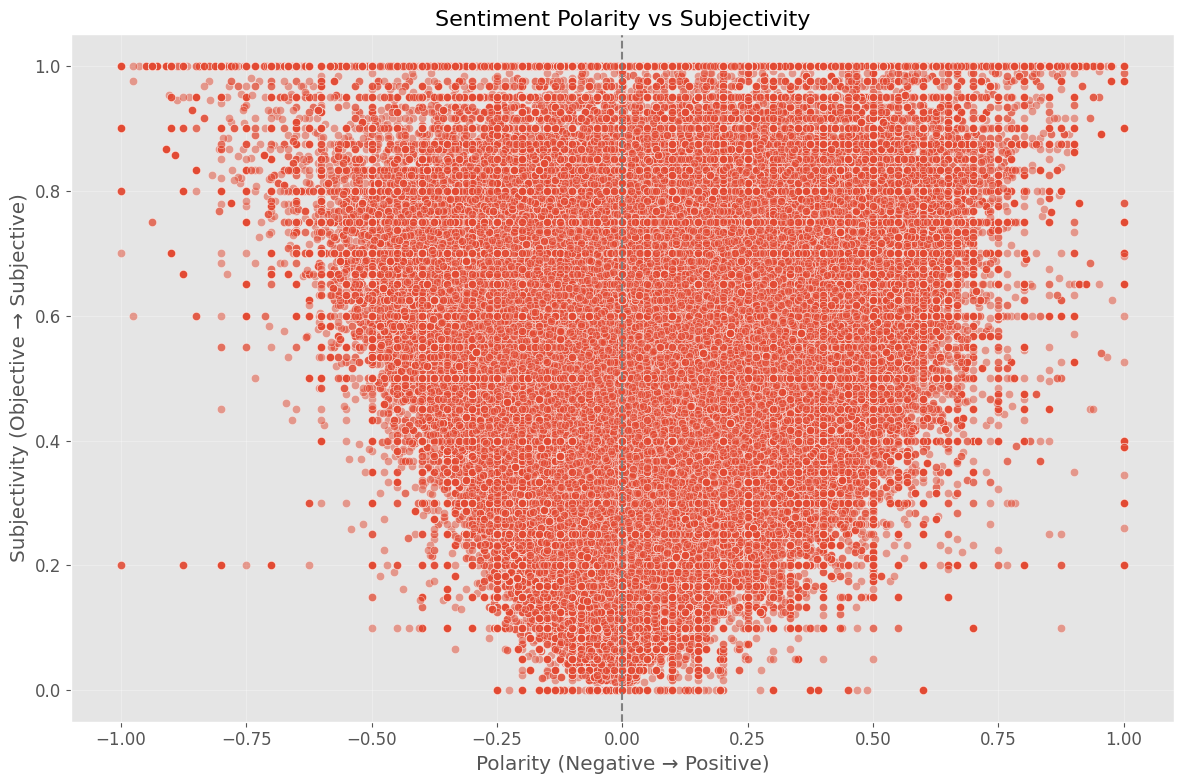

In [8]:
# Sentiment Analysis - Exploring emotional tone of sentences using a Spark UDF
from textblob import TextBlob
import pandas as pd
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType

# Define a UDF to compute polarity and subjectivity
def get_sentiment(text):
    if text is None or str(text).strip() == '':
        return (float('nan'), float('nan'))
    blob = TextBlob(str(text))
    return (float(blob.sentiment.polarity), float(blob.sentiment.subjectivity))

sentiment_udf = F.udf(get_sentiment, 'struct<polarity:float,subjectivity:float>')

# Apply the UDF to the DataFrame
sentiment_df = df_sentences.withColumn(
    "sentiment", sentiment_udf(F.col("sentence"))
).withColumn("polarity", F.col("sentiment.polarity")) \
    .withColumn("subjectivity", F.col("sentiment.subjectivity"))

# Convert to pandas for visualization
sentiment_pd = sentiment_df.select(
    'id', 'sentence_idx', 'sentence', 'polarity', 'subjectivity'
).toPandas()

# Plot sentiment polarity distribution with log-scaled y-axis
plt.figure(figsize=(14, 6))
sns.histplot(sentiment_pd['polarity'], kde=True)
plt.yscale('log')
plt.title('Sentiment Polarity Distribution of Sentences', fontsize=16)
plt.xlabel('Polarity (Negative → Positive)')
plt.ylabel('Frequency (log scale)')
plt.grid(True, alpha=0.3)
plt.axvline(x=0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

# Plot subjectivity distribution with log-scaled y-axis
plt.figure(figsize=(14, 6))
sns.histplot(sentiment_pd['subjectivity'], kde=True)
plt.yscale('log')
plt.title('Subjectivity Distribution of Sentences', fontsize=16)
plt.xlabel('Subjectivity Score (0 = Objective, 1 = Subjective)')
plt.ylabel('Frequency (log scale)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create a scatter plot of polarity vs subjectivity
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    x='polarity',
    y='subjectivity',
    data=sentiment_pd,
    alpha=0.5)
plt.title('Sentiment Polarity vs Subjectivity', fontsize=16)
plt.xlabel('Polarity (Negative → Positive)')
plt.ylabel('Subjectivity (Objective → Subjective)')
plt.axvline(x=0, color='gray', linestyle='--')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Named Entity Recognition

Let's extract named entities (people, places, organizations, dates, etc.) from the sentences to understand what kinds of entities are mentioned in the text.

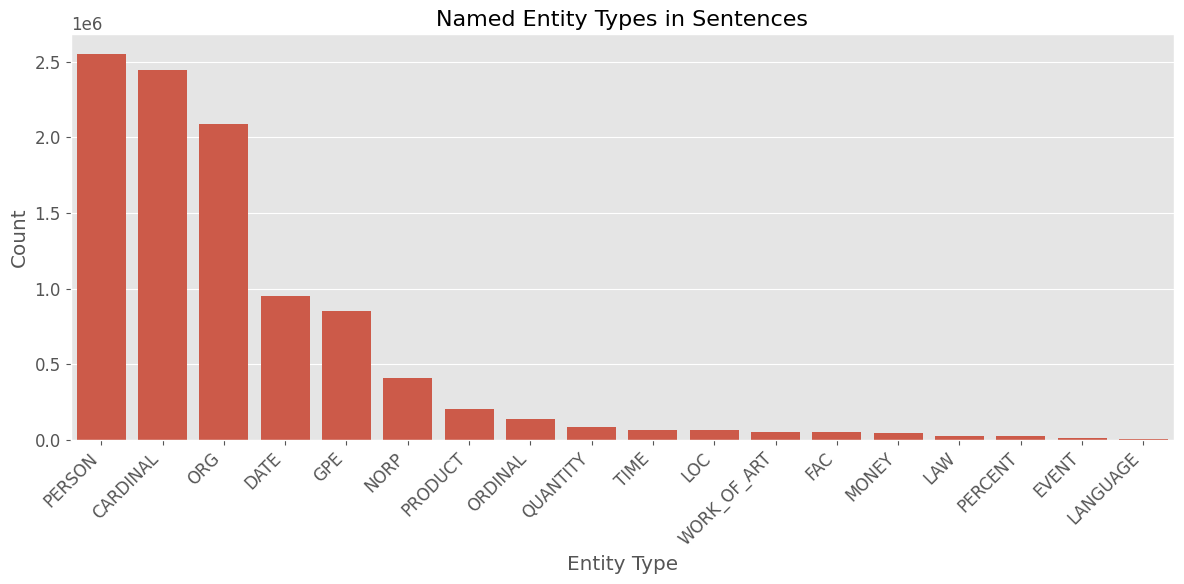


Most common ORG entities:
  - un: 65399
  - Ãªtre: 10545
  - fig: 7339
  - trÃ¨s: 7162
  - che: 6983

Most common PERSON entities:
  - Fig: 18261
  - oÃ¹: 7324
  - ¦: 6101
  - mÃªme: 4392
  - jÃ: 4192

Most common PRODUCT entities:
  - mÃªme: 4499
  - quâil: 3733
  - dâun: 2989
  - lâon: 2941
  - dâune: 1863

Most common NORP entities:
  - dans: 108431
  - dem: 16615
  - diese: 11866
  - Dans: 9603
  - French: 5439

Most common CARDINAL entities:
  - 1: 143812
  - 2: 106451
  - 3: 84272
  - two: 71457
  - one: 66789

Most common GPE entities:
  - London: 13140
  - Paris: 11721
  - England: 8712
  - Esq: 6811
  - M.D.: 6360

Most common PERCENT entities:
  - 1%: 463
  - 2%: 385
  - 5%: 367
  - 10%: 326
  - 3%: 276

Most common DATE entities:
  - the year: 18913
  - daily: 6520
  - the day: 3643
  - 14: 3436
  - 46: 3050

Most common LAW entities:
  - the Housing Act: 633
  - Section 7: 409
  - Finger: 211
  - CHAPTER II: 185
  - Prop: 170

Most common LOC entities:
  - Europe: 

In [21]:
# Named Entity Recognition using spaCy and a pandas UDF (per partition)
# Note: You may need to install spaCy and download the English model:
# !pip install spacy
# !python -m spacy download en_core_web_sm

import pandas as pd
from collections import Counter
import pyspark.sql.functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from typing import Iterator

def extract_entities_partition(pdf_iter: Iterator[pd.DataFrame]) -> Iterator[pd.DataFrame]:
    import spacy
    nlp = spacy.load('en_core_web_sm')
    rows = []
    for pdf in pdf_iter:
        for row in pdf.itertuples(index=False):
            text = getattr(row, 'sentence', None)
            id_val = getattr(row, 'id', None)
            idx_val = getattr(row, 'sentence_idx', None)
            if text is not None and str(text).strip() != '':
                doc = nlp(str(text)[:10000])
                for ent in doc.ents:
                    rows.append({
                        'id': id_val,
                        'sentence_idx': idx_val,
                        'entity_text': ent.text,
                        'entity_label': ent.label_
                    })
    yield pd.DataFrame(rows, columns=['id', 'sentence_idx', 'entity_text', 'entity_label'])

# Define output schema
entity_schema = StructType([
    StructField('id', StringType()),
    StructField('sentence_idx', IntegerType()),
    StructField('entity_text', StringType()),
    StructField('entity_label', StringType())
])

# Apply the pandas UDF
entities_df = df_sentences.mapInPandas(extract_entities_partition, schema=entity_schema)

# Convert to pandas for visualization
entities_pd = entities_df.toPandas()

# Count entity types
entity_type_counts = entities_pd['entity_label'].value_counts().reset_index()
entity_type_counts.columns = ['Entity Type', 'Count']

# Plot entity type distribution
plt.figure(figsize=(12, 6))
sns.barplot(x='Entity Type', y='Count', data=entity_type_counts)
plt.title('Named Entity Types in Sentences', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Show most common entities by type
most_common_entities = {}
for entity_type in entities_pd['entity_label'].unique():
    entities_of_type = entities_pd[entities_pd['entity_label'] == entity_type]['entity_text']
    most_common = Counter(entities_of_type).most_common(5)
    if most_common:
        most_common_entities[entity_type] = most_common

for entity_type, common_entities in most_common_entities.items():
    print(f"\nMost common {entity_type} entities:")
    for entity, count in common_entities:
        print(f"  - {entity}: {count}")

## Text Readability Analysis

Let's analyze the readability of the sentences using standard metrics like Flesch-Kincaid Grade Level.

,sentence_idx,flesch_reading_ease,flesch_kincaid_grade,smog_index,coleman_liau_index,automated_readability_index,dale_chall_readability_score
count,3.838512e+06,3.838512e+06,3.838512e+06,3.838512e+06,3.838512e+06,3.838512e+06,3.838512e+06
mean,7.788900e+03,5.154970e+01,1.094981e+01,1.139676e+01,1.078238e+01,1.359353e+01,1.423556e+01
std,1.843395e+04,2.800148e+01,6.036332e+00,4.798405e+00,6.202784e+00,8.201908e+00,4.530457e+00
min,0.000000e+00,-1.109461e+02,0.000000e+00,3.129100e+00,-1.986667e+01,-1.469667e+01,0.000000e+00
25%,8.960000e+02,3.442500e+01,6.620000e+00,8.841846e+00,7.357143e+00,8.059375e+00,1.043143e+01
50%,2.847000e+03,5.286800e+01,1.035000e+01,1.120814e+01,1.061111e+01,1.277200e+01,1.300656e+01
75%,7.556000e+03,7.079455e+01,1.463000e+01,1.455459e+01,1.393333e+01,1.824125e+01,1.943604e+01
max,4.039720e+05,1.349827e+02,3.000000e+01,3.225850e+01,2.504000e+02,5.160100e+02,2.369210e+01


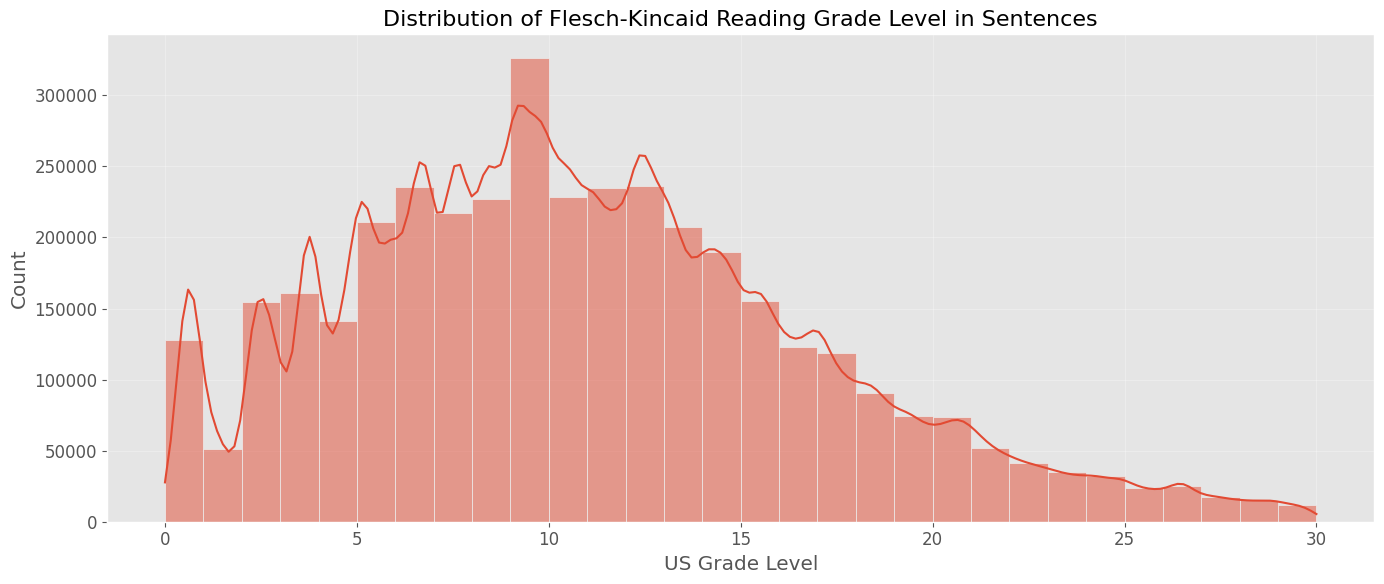

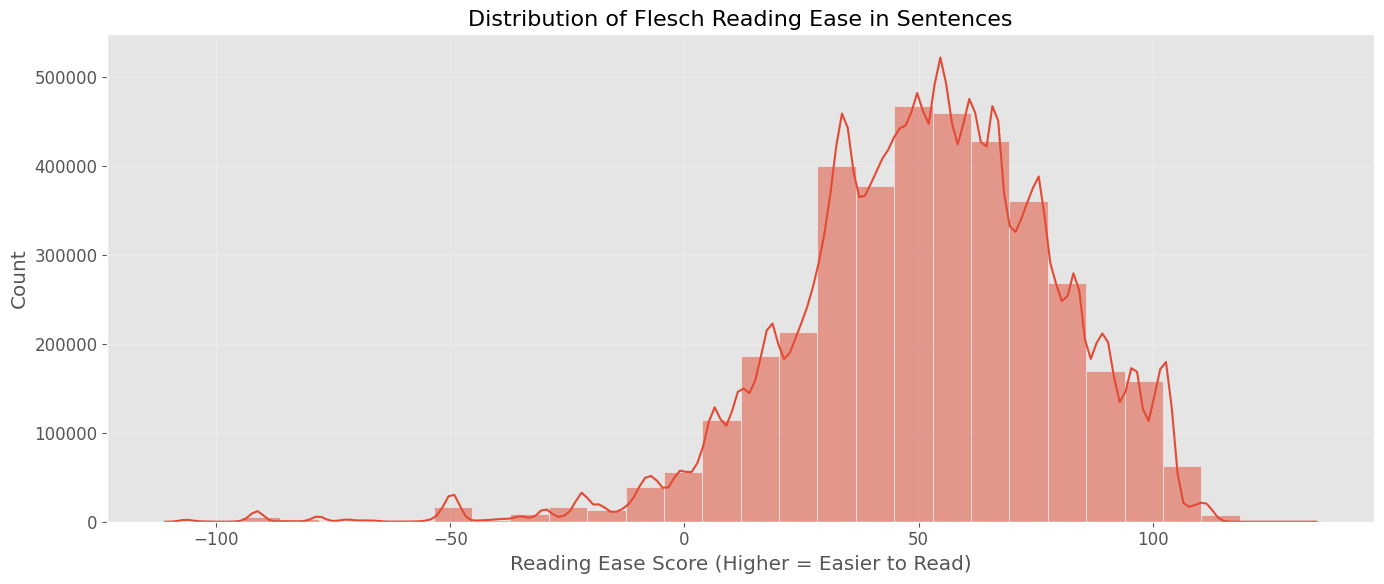

In [7]:
# Text Readability Analysis using a Spark UDF (vectorized, avoids row iteration)
import textstat
import pandas as pd

from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import FloatType, StructType, StructField

# Define a pandas UDF to compute readability metrics
@pandas_udf(
    StructType([
        StructField("flesch_reading_ease", FloatType()),
        StructField("flesch_kincaid_grade", FloatType()),
        StructField("smog_index", FloatType()),
        StructField("coleman_liau_index", FloatType()),
        StructField("automated_readability_index", FloatType()),
        StructField("dale_chall_readability_score", FloatType())
    ])
)
def readability_udf(sentences: pd.Series) -> pd.DataFrame:
    data = {
        "flesch_reading_ease": [],
        "flesch_kincaid_grade": [],
        "smog_index": [],
        "coleman_liau_index": [],
        "automated_readability_index": [],
        "dale_chall_readability_score": []
    }
    for text in sentences:
        if pd.isna(text) or not str(text).strip():
            data["flesch_reading_ease"].append(float('nan'))
            data["flesch_kincaid_grade"].append(float('nan'))
            data["smog_index"].append(float('nan'))
            data["coleman_liau_index"].append(float('nan'))
            data["automated_readability_index"].append(float('nan'))
            data["dale_chall_readability_score"].append(float('nan'))
            continue
        try:
            data["flesch_reading_ease"].append(textstat.flesch_reading_ease(text))
            data["flesch_kincaid_grade"].append(textstat.flesch_kincaid_grade(text))
            data["smog_index"].append(textstat.smog_index(text))
            data["coleman_liau_index"].append(textstat.coleman_liau_index(text))
            data["automated_readability_index"].append(textstat.automated_readability_index(text))
            data["dale_chall_readability_score"].append(textstat.dale_chall_readability_score(text))
        except Exception:
            data["flesch_reading_ease"].append(float('nan'))
            data["flesch_kincaid_grade"].append(float('nan'))
            data["smog_index"].append(float('nan'))
            data["coleman_liau_index"].append(float('nan'))
            data["automated_readability_index"].append(float('nan'))
            data["dale_chall_readability_score"].append(float('nan'))
    return pd.DataFrame(data)

# Filter sentences and apply the UDF
readability_df = df_sentences.filter(F.length('sentence') > 20) \
    .withColumn("readability", readability_udf("sentence")) \
    .select("id", "sentence_idx", "sentence", "readability.*")

# Convert to pandas for analysis and plotting
readability_pd = readability_df.toPandas()

# Remove outliers
readability_pd = readability_pd[
    (readability_pd['flesch_kincaid_grade'] >= 0) &
    (readability_pd['flesch_kincaid_grade'] <= 30)
]

# Calculate summary statistics
readability_stats = readability_pd.describe()
display(readability_stats)

# Plot distribution of reading level
plt.figure(figsize=(14, 6))
sns.histplot(
    readability_pd['flesch_kincaid_grade'].dropna(),
    kde=True, bins=30)
plt.title(
    'Distribution of Flesch-Kincaid Reading Grade Level in Sentences',
    fontsize=16)
plt.xlabel('US Grade Level')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot reading ease
plt.figure(figsize=(14, 6))
sns.histplot(
    readability_pd['flesch_reading_ease'].dropna(),
    kde=True, bins=30)
plt.title(
    'Distribution of Flesch Reading Ease in Sentences',
    fontsize=16)
plt.xlabel('Reading Ease Score (Higher = Easier to Read)')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Topic Modeling

Let's use Latent Dirichlet Allocation (LDA) to discover abstract topics in the sentence collection.

In [11]:
# Topic modeling using LDA (Latent Dirichlet Allocation)
from pyspark.ml.clustering import LDA

# Prepare the data for LDA - using the term frequency data from previous analysis
# Filter out documents with empty word lists to avoid errors
lda_input = sentences_term_freq_df.filter(F.size("clean_words") > 0)

# Number of topics to extract
num_topics = 20

# Create an LDA model
lda = LDA(k=num_topics, maxIter=10, featuresCol="term_freq")
sentences_lda_model = lda.fit(lda_input)

# Get topics and their terms
sentences_topics = sentences_lda_model.describeTopics()
sentences_topics.show(truncate=False)

# Convert topics to a more interpretable format
@F.udf(returnType=ArrayType(StringType()))
def map_term_indices_to_words(termIndices, vocabulary):
    return [vocabulary[idx] for idx in termIndices]

# Apply UDF to get terms for each topic
sentences_topics_with_terms = sentences_topics.withColumn(
    "terms", 
    map_term_indices_to_words(
        col("termIndices"), 
        F.array([F.lit(word) for word in sentences_vocab])
    )
)

# Show topics with their terms
sentences_topics_with_terms.select("topic", "terms", "termWeights").show(truncate=100)

+-----+---------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                        |termWeights                                                                                                                                                                                                                   |
+-----+---------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[95, 327, 55, 154, 19, 73, 144, 678, 58, 17]       |[0.0271029573660013, 0.017368794269030544, 0.015041009295217957, 0.012460158392589673, 0.012

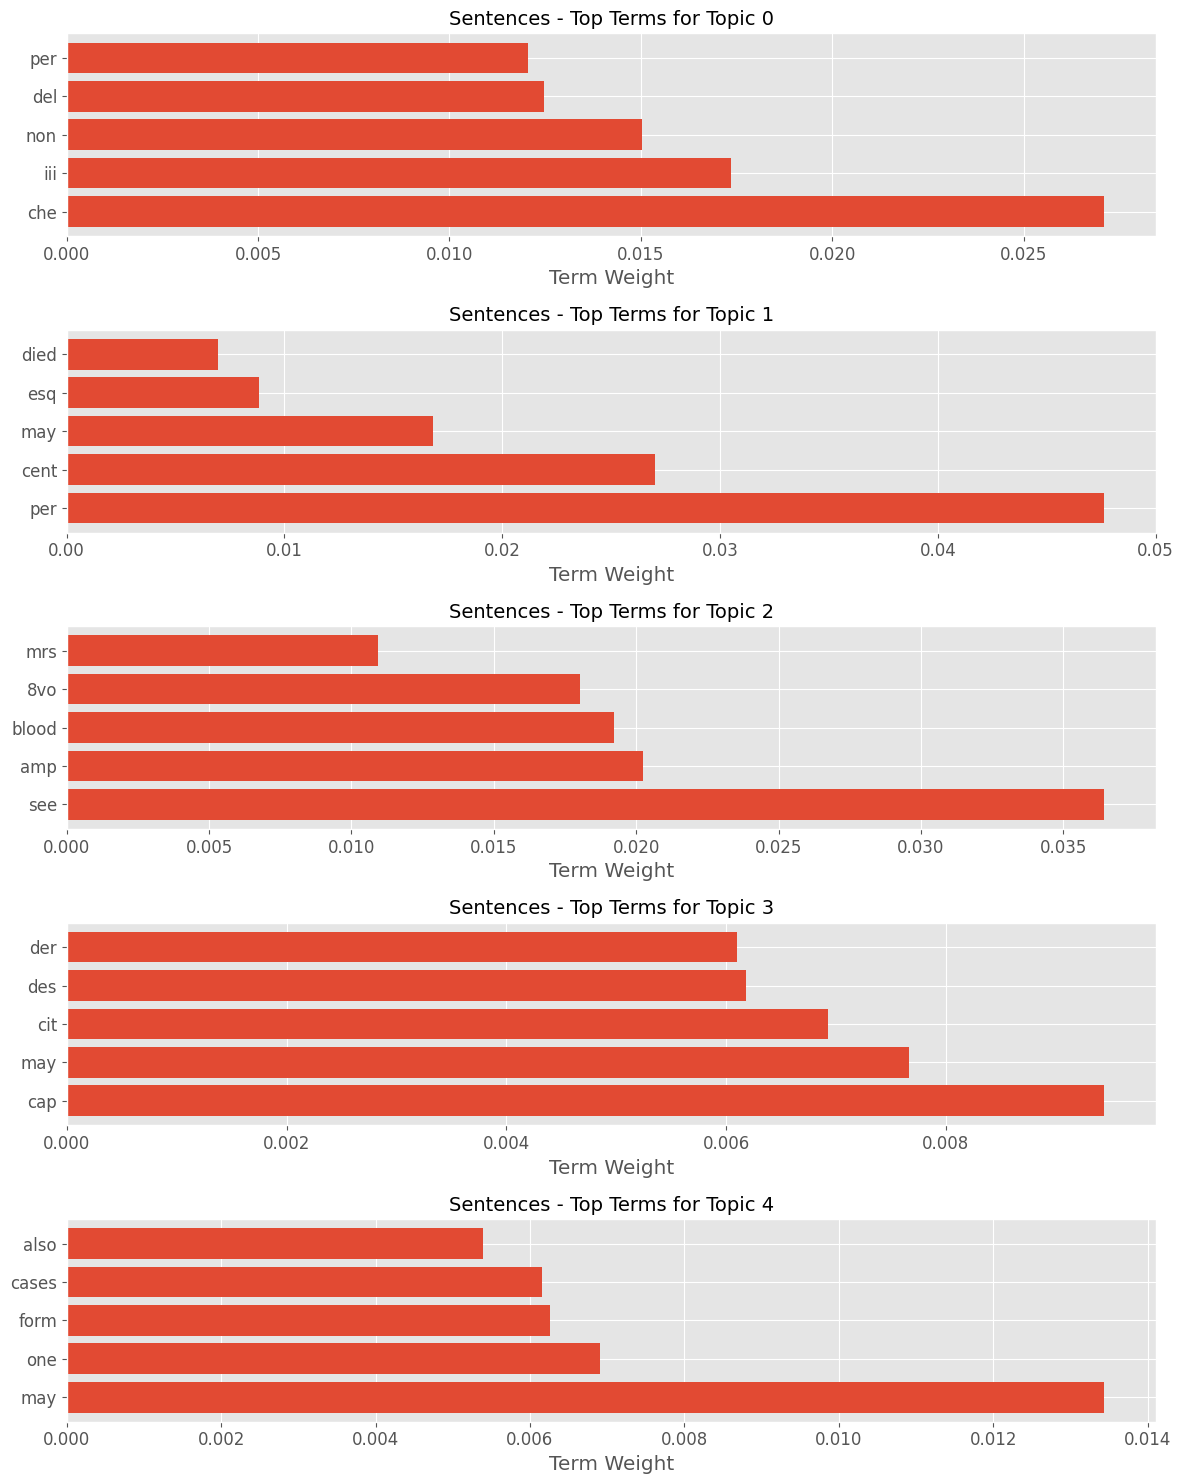

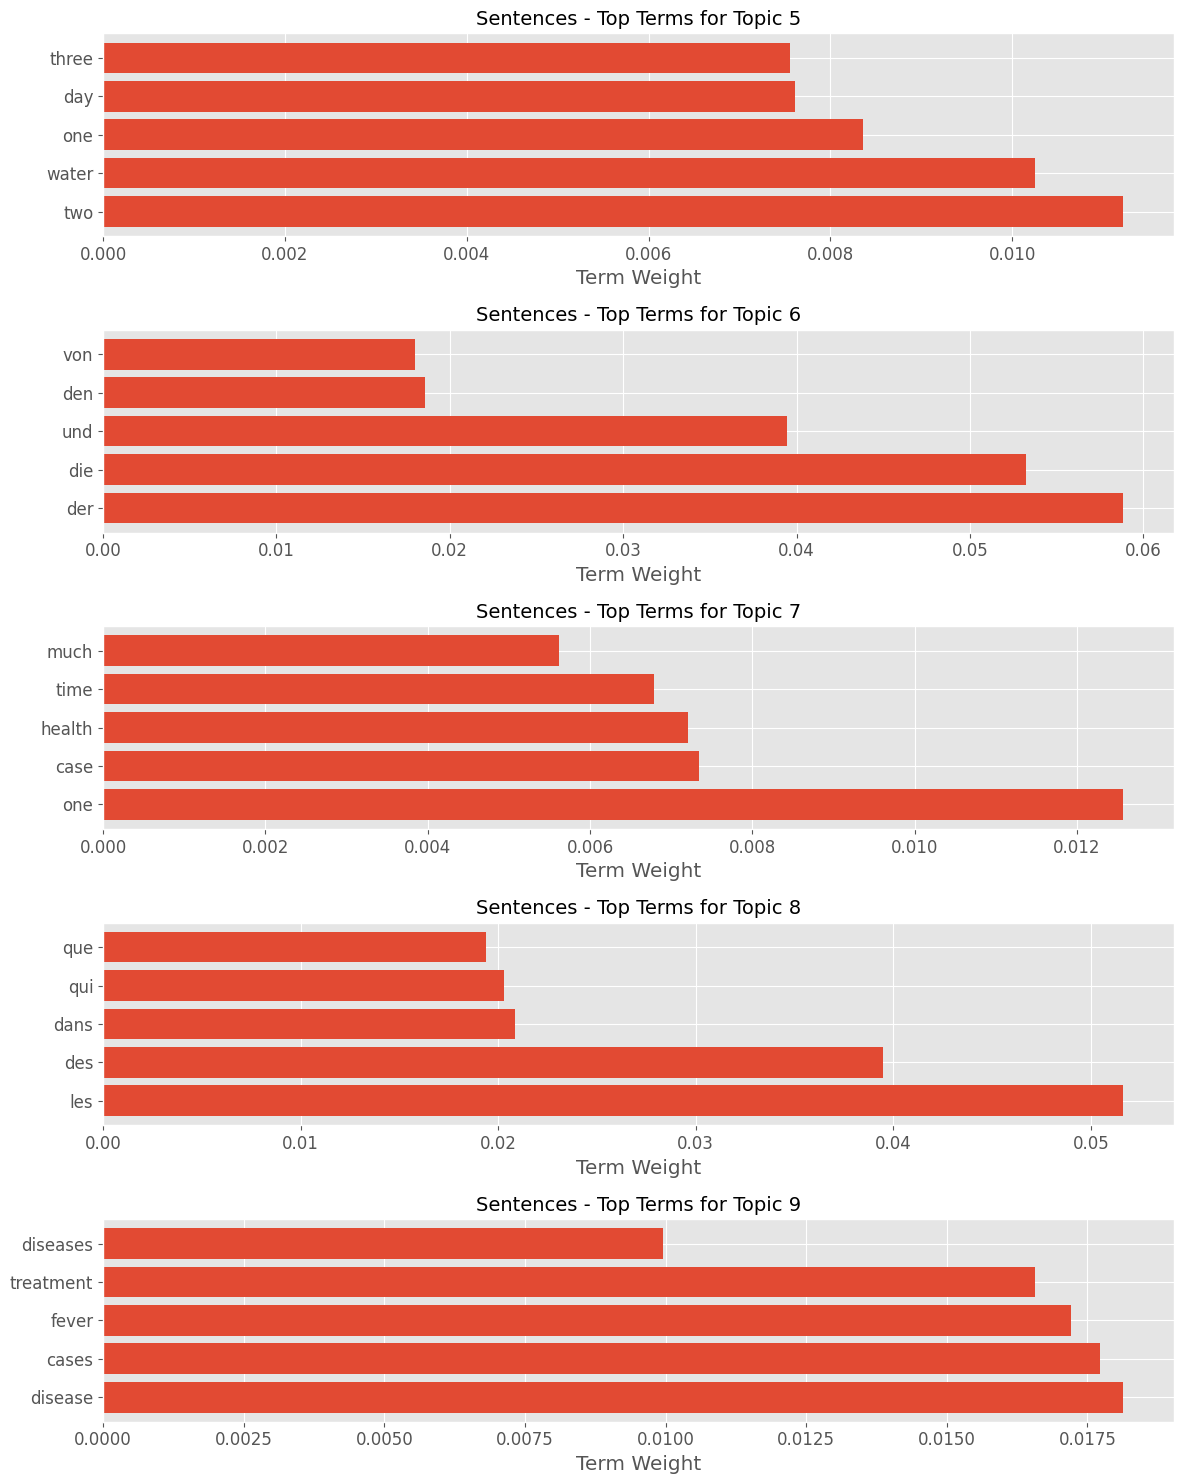

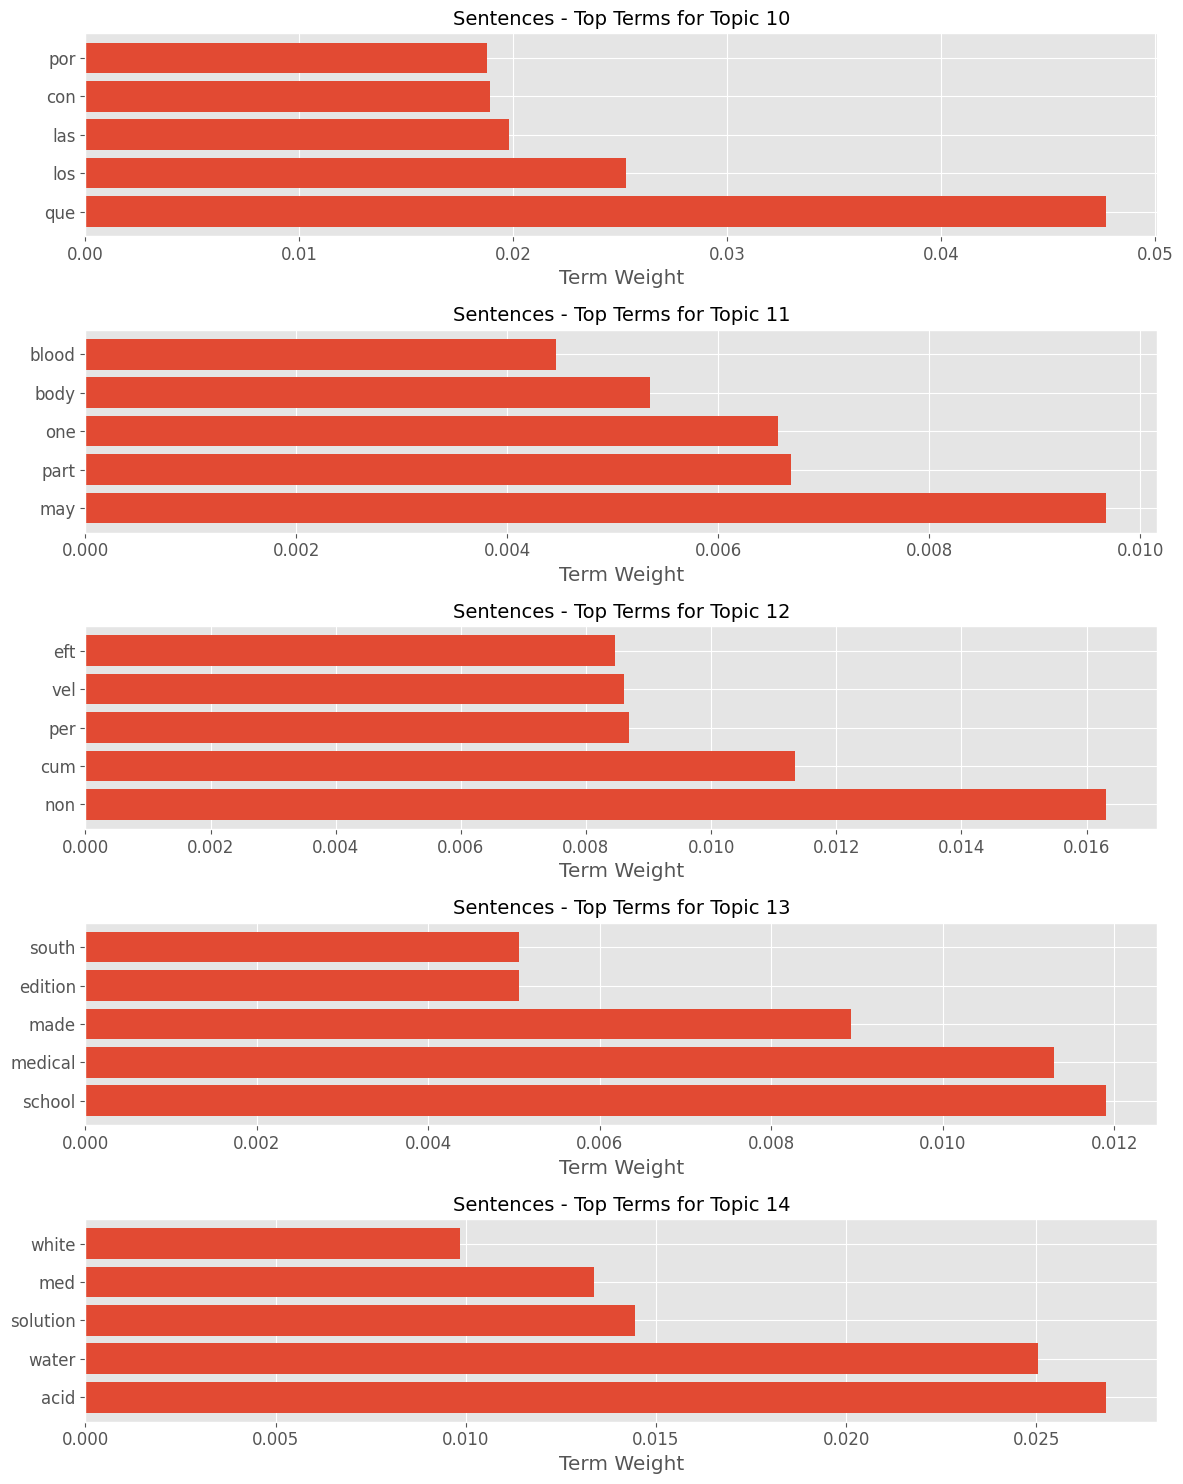

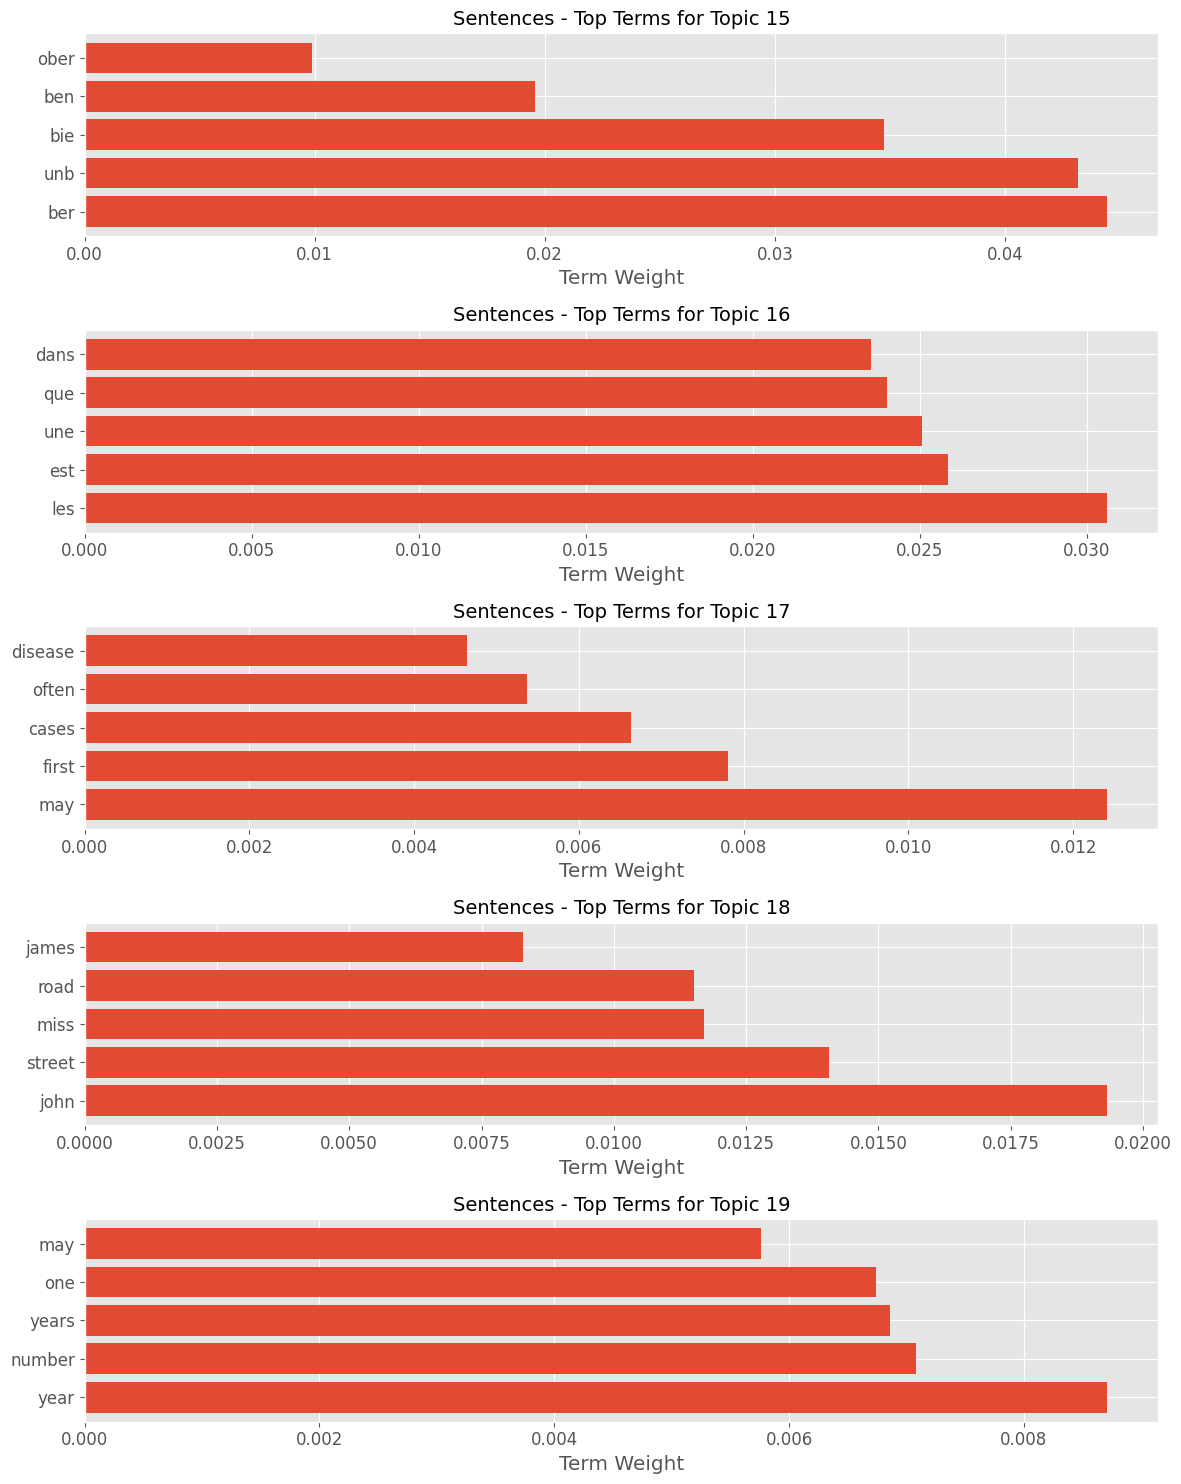

In [13]:
# Visualize topics and their most important terms, 5 topics at a time
sentences_topics_df = sentences_topics_with_terms.toPandas()

def plot_topics(topics_df, field_name, num_terms=5):
    topics_to_plot = len(topics_df)
    fig, axes = plt.subplots(topics_to_plot, 1, figsize=(12, 3*topics_to_plot))
    if topics_to_plot == 1:
        axes = [axes]
    for i, (ax, (_, row)) in enumerate(zip(axes, topics_df.iterrows())):
        terms = row['terms'][:num_terms]
        weights = row['termWeights'][:num_terms]
        ax.barh(range(len(terms)), weights, align='center')
        ax.set_yticks(range(len(terms)))
        ax.set_yticklabels(terms)
        ax.set_title(f'Sentences - Top Terms for Topic {row["topic"]}', fontsize=14)
        ax.set_xlabel('Term Weight')
    plt.tight_layout()
    plt.show()

# Plot topics in batches of 5
batch_size = 5
for start in range(0, len(sentences_topics_df), batch_size):
    plot_topics(sentences_topics_df.iloc[start:start+batch_size], "Sentences")


## Text Clustering and Collection Segmentation

Let's segment the sentence collection based on text content to identify natural groupings using word embeddings and dimensionality reduction.

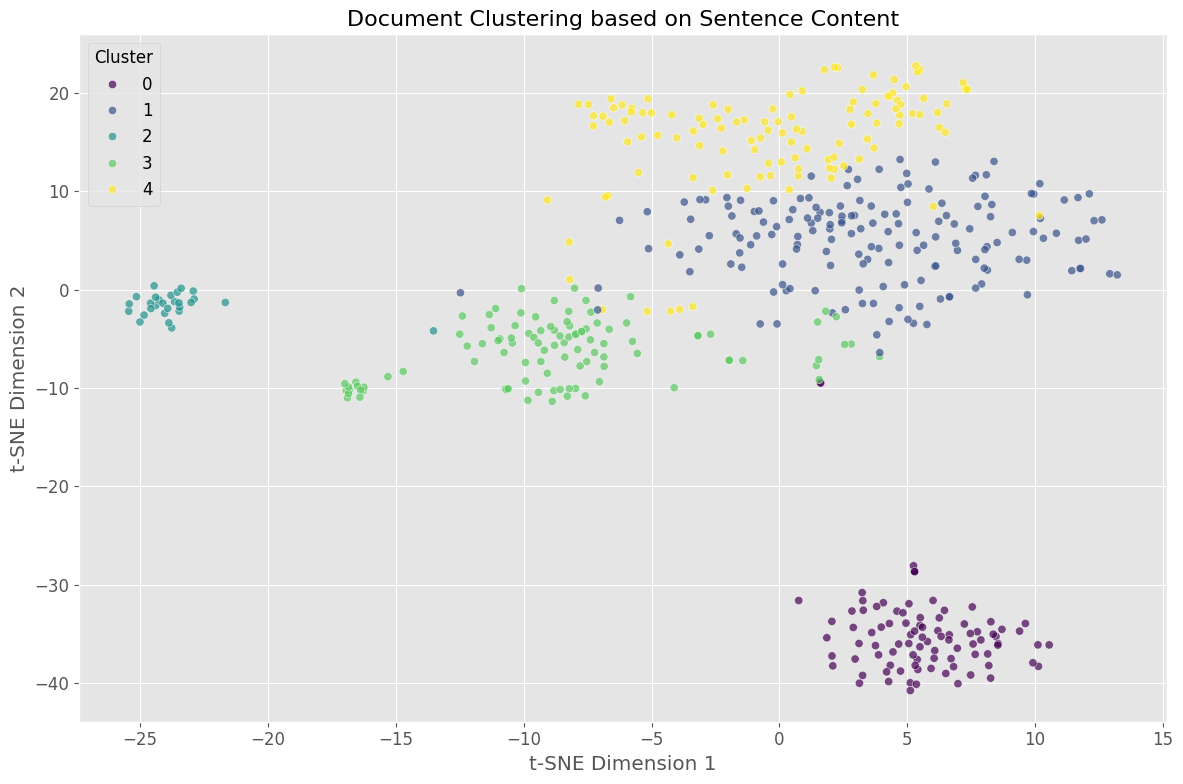

In [24]:
# Text clustering using embeddings and dimensionality reduction
from pyspark.ml.feature import Word2Vec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Use the cleaned word lists from earlier
# Train Word2Vec model to get document embeddings
w2v = Word2Vec(
    vectorSize=100,
    minCount=2,
    inputCol="clean_words",
    outputCol="document_vector"
)

# Train the model and transform the data - only using documents with words
sentences_valid_docs = sentences_cleaned_df.filter(F.size("clean_words") > 0)
sentences_w2v_model = w2v.fit(sentences_valid_docs)
sentences_doc_vectors = sentences_w2v_model.transform(sentences_valid_docs)

# Convert to pandas for visualization (limit to a sample for better performance)
sentences_doc_vectors_pd = sentences_doc_vectors.select(
    "id", "sentence_idx", "document_vector").sample(False, 0.1, seed=42).limit(500).toPandas()

# Convert vectors to numpy arrays for dimensionality reduction
sentences_vectors = np.array(sentences_doc_vectors_pd['document_vector'].tolist())

# Apply t-SNE for dimensionality reduction
if len(sentences_vectors) > 0:
    tsne = TSNE(n_components=2, random_state=42)
    sentences_vectors_2d = tsne.fit_transform(sentences_vectors)
    
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    sentences_clusters = kmeans.fit_predict(sentences_vectors)
    
    # Create visualization dataframe
    sentences_viz_df = pd.DataFrame({
        'id': sentences_doc_vectors_pd['id'],
        'sentence_idx': sentences_doc_vectors_pd['sentence_idx'],
        'x': sentences_vectors_2d[:, 0],
        'y': sentences_vectors_2d[:, 1],
        'cluster': sentences_clusters
    })
    
    # Visualize clusters
    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(
        x='x',
        y='y',
        data=sentences_viz_df,
        hue='cluster',
        palette='viridis',
        alpha=0.7)
    plt.title('Document Clustering based on Sentence Content', fontsize=16)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

## Temporal Pattern Analysis

Let's analyze if the sentence data contains temporal references and patterns.

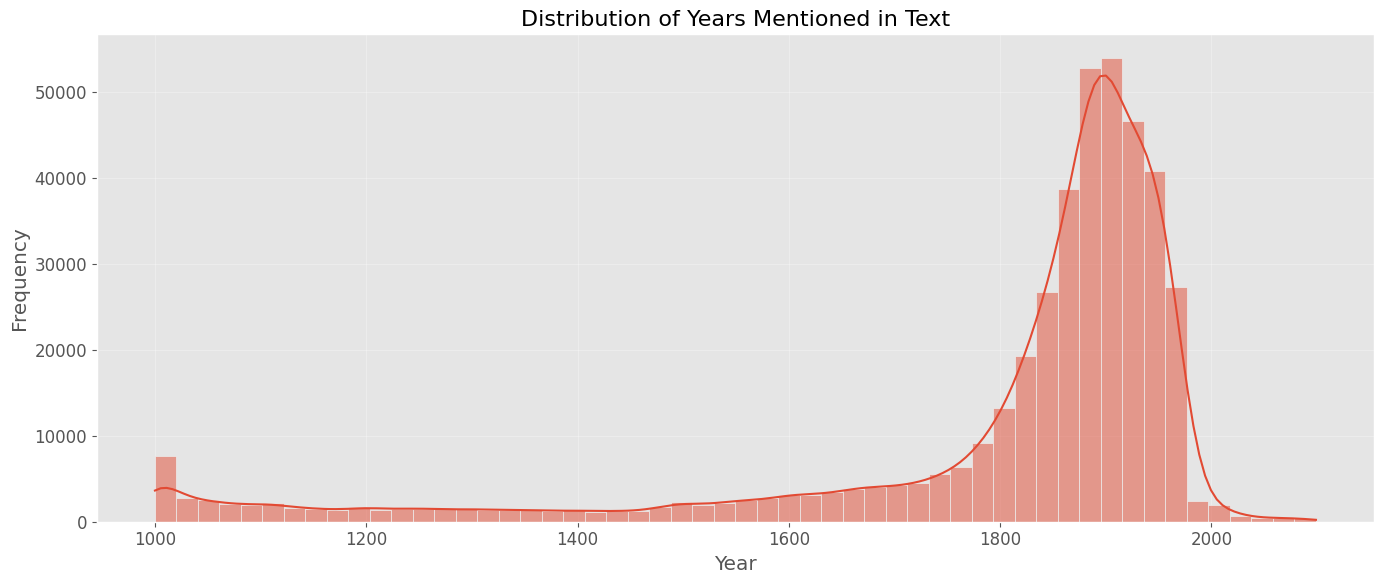


Most common years mentioned:
  - 1000: 4485
  - 1890: 3532
  - 1936: 3457
  - 1891: 3371
  - 1900: 3320
  - 1901: 3303
  - 1904: 3038
  - 1895: 3032
  - 1892: 3026
  - 1894: 2994

Most common centuries mentioned:
  - 18th century: 79
  - 17th century: 66
  - 16th century: 46
  - 19th century: 46
  - 15th century: 32

Most common decades mentioned:
  - 1980s: 11
  - 1970s: 10
  - 1960s: 9
  - 1950s: 8
  - 1990s: 5


In [6]:
# Extract and analyze temporal references in text using a Spark UDF

import re
from pyspark.sql.types import ArrayType, StringType, StructType, StructField
from pyspark.sql import functions as F

# Regular expressions for finding years, centuries, and decades
year_pattern = r'\b1[0-9]{3}\b|\b20[0-9]{2}\b'  # Years from 1000-2099
century_pattern = r'\b(?:1[0-9]|20)(?:th|st) century\b'
decade_pattern = r'\b(?:1[0-9]|20)[0-9]0s\b'  # 1000s-2090s decades

# Define a Spark UDF to extract temporal references from a sentence
@F.udf(returnType=StructType([
    StructField("years", ArrayType(StringType())),
    StructField("centuries", ArrayType(StringType())),
    StructField("decades", ArrayType(StringType()))
]))
def extract_temporal_refs_udf(text):
    if text is None or text.strip() == '':
        return ([], [], [])
    years = re.findall(year_pattern, text)
    centuries = re.findall(century_pattern, text)
    decades = re.findall(decade_pattern, text)
    return (years, centuries, decades)

# Apply the UDF to the sentences
temporal_refs_df = df_sentences.withColumn(
    "temporal_refs", extract_temporal_refs_udf(F.col("sentence"))
).select(
    "id",
    "sentence",
    F.col("temporal_refs.years").alias("years"),
    F.col("temporal_refs.centuries").alias("centuries"),
    F.col("temporal_refs.decades").alias("decades")
)

# Aggregate all temporal references
temporal_refs_pd = temporal_refs_df.select("years", "centuries", "decades").toPandas()

from itertools import chain
from collections import Counter

all_years = list(chain.from_iterable(temporal_refs_pd["years"]))
all_centuries = list(chain.from_iterable(temporal_refs_pd["centuries"]))
all_decades = list(chain.from_iterable(temporal_refs_pd["decades"]))

# Convert years to integers for histogram
year_ints = [int(y) for y in all_years if y.isdigit()]
if year_ints:
    year_range = max(year_ints) - min(year_ints)
    plt.figure(figsize=(14, 6))
    sns.histplot(year_ints, bins=max(1, int(year_range / 20)), kde=True)
    plt.title('Distribution of Years Mentioned in Text', fontsize=16)
    plt.xlabel('Year')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Show most common temporal references
print("\nMost common years mentioned:")
for year, count in Counter(all_years).most_common(10):
    print(f"  - {year}: {count}")

print("\nMost common centuries mentioned:")
for century, count in Counter(all_centuries).most_common(5):
    print(f"  - {century}: {count}")

print("\nMost common decades mentioned:")
for decade, count in Counter(all_decades).most_common(5):
    print(f"  - {decade}: {count}")


## Conclusions and Insights

Based on our sentence-level text analysis, here are some key findings:

1. **Sentence Length and Word Count**: We've examined how sentence length and word count are distributed across the ALTO text, helping understand the structure of the text at a granular level.

2. **Term Frequency**: We've identified the most common terms in the sentences, revealing frequently occurring words that characterize the content.

3. **N-gram Analysis**: Through bigram and trigram analysis, we've discovered common phrases and multi-word expressions in the text.

4. **Text Complexity**: We've measured lexical diversity and average word length to gauge the complexity of language used in the sentences.

5. **Sentiment Analysis**: We've analyzed the emotional tone and subjectivity of the sentences to understand their sentiment patterns.

6. **Named Entity Recognition**: We've identified people, places, organizations, and other entities mentioned in the sentences, providing insight into what the text references.

7. **Readability Metrics**: We've calculated various readability scores to assess the accessibility and complexity of the text.

8. **Topic Modeling**: Using LDA, we've discovered latent topics in the sentence collection, revealing thematic patterns that might not be explicitly categorized.

9. **Text Clustering**: We've segmented the sentence collection based on text content to identify natural groupings using word embeddings and dimensionality reduction.

10. **Temporal References**: We've extracted and analyzed time-related information to understand the historical periods referenced in the text.

These analyses provide a rich understanding of the textual content in the ALTO text corpus at the sentence level, which can inform further research, text processing, and analysis.

In [ ]:
# Extract and analyze temporal references in text
try:
    import re
    import pandas as pd
    from collections import Counter
    
    # Sample data for temporal analysis
    temporal_sample = df_sentences.select('id', 'sentence_idx', 'sentence').sample(False, 0.1, seed=42).toPandas()
    
    # Regular expressions for finding years and centuries
    year_pattern = r'\b1[0-9]{3}\b|\b20[0-9]{2}\b'  # Years from 1000-2099
    century_pattern = r'\b(?:1[0-9]|20)th century\b|\b(?:1[0-9]|20)st century\b'  # 10th-21st century
    decade_pattern = r'\b(?:1[0-9]|20)[0-9]0s\b'  # 1000s-2090s decades
    
    # Function to extract temporal references
    def extract_temporal_refs(text):
        if pd.isna(text) or text.strip() == '':
            return [], [], []
            
        years = re.findall(year_pattern, text)
        centuries = re.findall(century_pattern, text)
        decades = re.findall(decade_pattern, text)
        
        return years, centuries, decades
    
    # Collect all temporal references
    all_years = []
    all_centuries = []
    all_decades = []
    
    # Process sentences
    for _, row in temporal_sample.iterrows():
        if pd.notna(row['sentence']) and row['sentence'].strip():
            years, centuries, decades = extract_temporal_refs(row['sentence'])
            all_years.extend(years)
            all_centuries.extend(centuries)
            all_decades.extend(decades)
    
    # Convert years to integers for histogram
    year_ints = [int(y) for y in all_years if y.isdigit()]
    
    # Plot distribution of years mentioned if there are any
    if year_ints:
        # Year range
        year_range = max(year_ints) - min(year_ints) if year_ints else 100
        bin_count = max(20, int(year_range / 20))
        
        plt.figure(figsize=(14, 6))
        sns.histplot(year_ints, bins=bin_count, kde=True)
        plt.title('Distribution of Years Mentioned in Sentences', fontsize=16)
        plt.xlabel('Year')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("No years found in the sampled sentences.")
    
    # Show most common temporal references
    print("\nMost common years mentioned:")
    for year, count in Counter(all_years).most_common(10):
        print(f"  - {year}: {count}")
        
    print("\nMost common centuries mentioned:")
    for century, count in Counter(all_centuries).most_common(5):
        print(f"  - {century}: {count}")
        
    print("\nMost common decades mentioned:")
    for decade, count in Counter(all_decades).most_common(5):
        print(f"  - {decade}: {count}")
        
except Exception as e:
    print(f"Error in temporal analysis: {e}")